In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime as dt
from pandas_datareader import DataReader as DR
import seaborn as sb
import numdifftools as nd
from wquantiles import quantile
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

from scipy.stats import norm,t,truncnorm
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import multivariate_t as mvt
from scipy.spatial import Delaunay as TRI
from scipy.interpolate import LinearNDInterpolator as ITP
from scipy.optimize import minimize,root
from scipy.optimize import NonlinearConstraint as NonlinCons
from scipy.stats import gaussian_kde as sciKDE

from sklearn.linear_model import LinearRegression as Linear
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KernelDensity as sklKDE

import warnings
warnings.filterwarnings("ignore")

# Define the experiment class

In [2]:
class MLE:
    def __init__(self,dim,alpha,sigma,size,df=1):
        self.alpha=alpha
        self.VaR=norm.ppf(alpha)
        aVar=np.array([alpha*(1-alpha),4*(alpha*(1-alpha))**2])/norm.pdf(self.VaR)**2
        aErr=np.sqrt(aVar/size)
        print('Reference for a-var & a-err (direct, optimal): {} & {}'.format(np.round(aVar,4),np.round(aErr,4)))
        
        self.dim=dim
        self.T=lambda x: mvnorm.pdf(x=x,mean=np.zeros(dim))
        self.oP=lambda x,VaR: self.T(x)*np.abs(1.0*(x[:,0]<VaR)-self.alpha)/(2*self.alpha*(1-self.alpha))
        self.iP=lambda x: mvt.pdf(x=x,loc=np.zeros(dim),shape=sigma**2,df=df)
        self.iS=lambda size: mvt.rvs(size=size,loc=np.zeros(dim),shape=sigma**2,df=df)
        self.size=size
        
    def __estimate(self,S,W,name,asym=True):
        self.eVaR=quantile(S[:,0],W,self.alpha)
        err=self.eVaR-self.VaR
        if asym:
            w=W/np.sum(W)
            aVar=np.sum((w*(1.0*(S[:,0]<=self.eVaR)-self.alpha))**2)*W.size
            aVar/=norm.pdf(self.VaR)**2
            aErr=np.sqrt(aVar/W.size)
            ESS=1/np.sum(w**2)
            
            Wf=W*(S[:,0]<self.eVaR)
            wf=Wf/np.sum(Wf)
            ESSf=1/np.sum(wf**2)
            print('{} est: {:.4f}; err: {:.4f}; a-var: {:.4f}; a-err: {:.4f}; ESS: {:.0f}/{}; ESS(f): {:.0f}/{}'\
                  .format(name,self.eVaR,err,aVar,aErr,ESS,W.size,ESSf,W.size))
        else:
            print('{} est: {:.4f}; err: {:.4f}'.format(name,self.eVaR,err))
            
        if any(W<0):
            W[W<0]=0
            self.eVaR=quantile(S[:,0],W,self.alpha)
            err=self.eVaR-self.VaR
            print('(adjusted) {} est: {:.4f}; err: {:.4f}'.format(name,self.eVaR,err))
        
    def estimate_IS(self):
        S=self.iS(self.size)
        W=self.T(S)/self.iP(S)
        self.__estimate(S,W,'IS')
    
    def draw_TP(self,P,x,name,dim=0):
        X=np.zeros([x.size,self.dim])
        X[:,dim]=x
        fig,ax=plt.subplots(figsize=(7,4))
        ax.plot(x,self.T(X))
        ax.plot(x,self.oP(X,self.VaR))
        ax.plot(x,P(X))
        if name=='nonparametric':
            one=np.zeros(self.dim)
            one[dim]=1
            rW=np.array([self.h(one*loc,loc) for loc in self.rS])
            rW=rW/rW.max()*P(X).max()
            rWmeans=np.ones_like(rW)*rW.mean()

            ax.plot(x,self.mP(X))
            ax.hist(self.rS[:,dim],bins=2*rW.size,weights=rWmeans)
            ax.hist(self.rS[:,dim],bins=2*rW.size,weights=rW)
            ax.legend(['target','optimal proposal','nonparametric proposal',\
                       'mixture proposal','centers','centers with weight'])
        else:
            ax.legend(['target','optimal proposal','{} proposal'.format(name)])
            
        ax.set_title('{}-D target and {} proposal (cross-sectional view)'.format(self.dim,name))
        plt.show()
        
    def resample(self,size,ratio):
        S=self.iS(ratio*size)
        p=self.oP(S,self.eVaR)/self.iP(S)
        index=np.arange(S.shape[0])
        choice=np.random.choice(index,size,p=p/np.sum(p),replace=True)
        
        self.rS=S[choice]
        self.rSset=S[list(set(choice))]
        print('resampling rate: {}/{}'.format(self.rSset.shape[0],size))
        
    def estimate_NIS(self,rate,bdwth='scott',reg=0):
        self.kde=sciKDE(self.rS.T,bw_method=bdwth)
        cov=self.kde.covariance_factor()*np.cov(self.rS.T)
        print('bdwth: {}'.format(np.round(np.sqrt(np.diag(cov)),2)))
        self.h=lambda x,loc: mvnorm.pdf(x=x,mean=loc,cov=cov)
        self.G=lambda x: np.array([self.h(x,self.rSset[i])-self.h(x,self.rSset[0])\
                                   for i in range(1,self.rSset.shape[0])])
        
        self.nP=lambda x: self.kde.pdf(x.T)
        self.nS=lambda size: self.kde.resample(size).T
        S=self.nS(self.size)
        W=self.T(S)/self.nP(S)
        self.__estimate(S,W,'NIS')
        
        self.mP=lambda x: (1-rate)*self.iP(x)+rate*self.nP(x)
        self.mS=lambda size: np.vstack([self.iS(size-round(rate*size)),self.nS(round(rate*size))])
        self.S=self.mS(self.size)
        W=self.T(self.S)/self.mP(self.S)
        self.__estimate(self.S,W,'MIS')
        
    def estimate_RIS(self,vif=False):
        X=(self.G(self.S)/self.mP(self.S)).T
        if vif:
            if X.shape[1]<=100:
                ind=np.arange(X.shape[1])
            else:
                ind=np.random.choice(np.arange(X.shape[1]),100,replace=False)

            tmp=np.hstack([X,np.ones([X.shape[0],1])])
            Vif=np.zeros(ind.size)
            for i in range(ind.size):
                Vif[i]=VIF(tmp,ind[i])

            print('VIF: (min {:.4f}, median {:.4f}, mean {:.4f}, max {:.4f}, [>5] {}/{})'\
                  .format(Vif.min(),np.median(Vif),Vif.mean(),Vif.max(),np.sum(Vif>5),Vif.size))
            q1=np.quantile(Vif,0.75)
            rS=self.rSset[1:][ind[Vif>q1]]
            print('VIF>{:.4f}: mean {}, std {}'.format(q1,np.round(rS.mean(axis=0),4),np.round(rS.std(axis=0),4)))
            q2=np.quantile(Vif,0.25)
            rS=self.rSset[1:][ind[Vif<q2]]
            print('VIF<{:.4f}: mean {}, std {}'.format(q2,np.round(rS.mean(axis=0),4),np.round(rS.std(axis=0),4)))
        
        y2=self.T(self.S)/self.mP(self.S)
        y1=y2*(self.S[:,0]<=self.eVaR)
        self.reg1=Linear().fit(X,y1)
        self.reg2=Linear().fit(X,y2)
        print('Numerator R2: {:.4f}; Denominator R2: {:.4f}'.format(self.reg1.score(X,y1),self.reg2.score(X,y2)))
        
        W1=y1-X.dot(self.reg1.coef_)
        W2=y2-X.dot(self.reg2.coef_)
        aVar=np.sum((W1-self.alpha*W2)**2)/(np.sum(W2))**2
        aVar=W1.size*aVar/norm.pdf(self.VaR)**2
        aErr=np.sqrt(aVar/W1.size)
        print('RIS a-var: {:.4f}; a-err: {:.4f}'.format(aVar,aErr))
        
    def estimate_MLE(self,opt=True,NR=True):
        mP=self.mP(self.S)
        G=self.G(self.S)
        target=lambda zeta: -np.mean(np.log(mP+zeta.dot(G)))
        gradient=lambda zeta: -np.mean(G/(mP+zeta.dot(G)),axis=1)
        hessian=lambda zeta: (G/(mP+zeta.dot(G))**2).dot(G.T)/G.shape[1]
        zeta0=np.zeros(G.shape[0])
        grad0=gradient(zeta0)
        print('MLE reference:')
        print('origin: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
              .format(target(zeta0),grad0.min(),grad0.mean(),grad0.max(),grad0.std()))
        
        print()
        print('Theoretical results:')
        X=(G/mP).T
        XX=X-X.mean(axis=0)
        zeta1=np.linalg.solve(XX.T.dot(XX),X.sum(axis=0))
        print('MLE(The) zeta: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f}, norm {:.4f})'\
              .format(zeta1.min(),zeta1.mean(),zeta1.max(),zeta1.std(),np.sqrt(np.sum(zeta1**2))))
        grad1=gradient(zeta1)
        print('theory: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
              .format(target(zeta1),grad1.min(),grad1.mean(),grad1.max(),grad1.std()))
        W=(self.T(self.S)/mP)*(1-XX.dot(zeta1))
        print('reg weights: (min {:.4f}, mean {:.4f}, max {:.4f}, [<0] {}/{})'\
              .format(W.min(),W.mean(),W.max(),np.sum(W<0),W.size))
        self.__estimate(self.S,W,'RIS',asym=False)
        W=self.T(self.S)/(mP+zeta1.dot(G))
        print('mle weights (The): (min {:.4f}, mean {:.4f}, max {:.4f}, [<0] {}/{})'\
              .format(W.min(),W.mean(),W.max(),np.sum(W<0),W.size))
        self.__estimate(self.S,W,'MLE(The)',asym=False)
        
        if opt:
            zeta=zeta1 if target(zeta1)!=np.nan else zeta0
            begin=dt.now()
            if NR:
                res=root(lambda zeta: (gradient(zeta),hessian(zeta)),zeta,method='lm',jac=True)
            else:
                cons=({'type':'ineq','fun':lambda zeta: mP+zeta.dot(G),'jac':lambda zeta: G.T})
                res=minimize(target,zeta,method='SLSQP',jac=gradient,constraints=cons,\
                             options={'ftol':1e-8,'maxiter':1000})
            
            end=dt.now()
            print()
            print('Optimization results (spent {} seconds):'.format((end-begin).seconds))
            if res['success']:
                zeta=res['x']
                print('MLE(Opt) zeta: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f}, norm {:.4f})'\
                      .format(zeta.min(),zeta.mean(),zeta.max(),zeta.std(),np.sqrt(np.sum(zeta**2))))
                print('Dist(zeta(Opt),zeta(The))={:.4f}'.format(np.sqrt(np.sum((zeta-zeta1)**2))))
                grad=gradient(zeta)
                print('optimal: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
                      .format(target(zeta),grad.min(),grad.mean(),grad.max(),grad.std()))
                W=self.T(self.S)/(mP+zeta.dot(G))
                print('mle weights (Opt): (min {:.4f}, mean {:.4f}, max {:.4f}, [<0] {}/{})'\
                      .format(W.min(),W.mean(),W.max(),np.sum(W<0),W.size))
                self.__estimate(self.S,W,'MLE(Opt)',asym=False)
            else:
                print('MLE fail')

# Run the experiments

==IS==================================================IS==
Reference for a-var & a-err (direct, optimal): [4.4656 0.8485] & [0.0149 0.0065]
IS est: -1.6380; err: 0.0068; a-var: 12.7049; a-err: 0.0252; ESS: 4441/20000; ESS(f): 364/20000


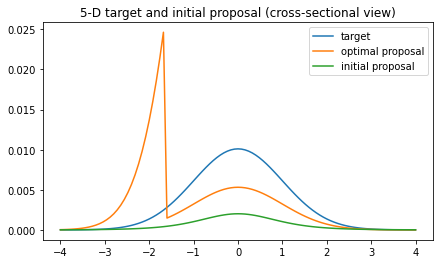

==NIS================================================NIS==
resampling rate: 186/200
bdwth: [0.96 0.78 0.71 0.85 0.67]
NIS est: -1.6386; err: 0.0063; a-var: 2.3777; a-err: 0.0109; ESS: 6478/20000; ESS(f): 2560/20000
MIS est: -1.6600; err: -0.0152; a-var: 2.4178; a-err: 0.0110; ESS: 7147/20000; ESS(f): 2403/20000


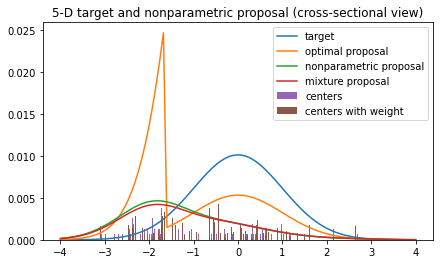

==RIS================================================RIS==
VIF: (min 1.2304, median 6.3472, mean 16.0446, max 201.0443, [>5] 55/100)
VIF>19.1798: mean [-0.9732 -0.1561 -0.1358 -0.2588 -0.0789], std [1.0156 0.8434 0.557  0.5712 0.5442]
VIF<2.6038: mean [-0.3447  0.0143 -0.3576  0.3222 -0.2925], std [1.5767 1.4261 1.2334 1.1987 1.5736]
Numerator R2: 0.3160; Denominator R2: 0.7906
RIS a-var: 1.1857; a-err: 0.0077


In [3]:
np.random.seed(1234)
print('==IS==================================================IS==')
mle=MLE(dim=5,alpha=0.05,sigma=2,size=20000,df=1)
mle.estimate_IS()
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('==NIS================================================NIS==')
mle.resample(200,100)
mle.estimate_NIS(0.9,reg=0)
mle.draw_TP(mle.nP,x,'nonparametric')
print('==RIS================================================RIS==')
mle.estimate_RIS(vif=True)

==IS==================================================IS==
Reference for a-var & a-err (direct, optimal): [4.4656 0.8485] & [0.0067 0.0029]
IS est: -1.6550; err: -0.0102; a-var: 12.6160; a-err: 0.0112; ESS: 21999/100000; ESS(f): 1832/100000


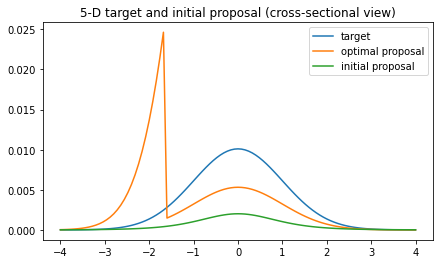

==NIS================================================NIS==
resampling rate: 932/1000
bdwth: [0.87 0.69 0.67 0.69 0.67]
NIS est: -1.6478; err: -0.0030; a-var: 1.5218; a-err: 0.0039; ESS: 44503/100000; ESS(f): 21270/100000
MIS est: -1.6395; err: 0.0054; a-var: 1.5918; a-err: 0.0040; ESS: 46011/100000; ESS(f): 19569/100000


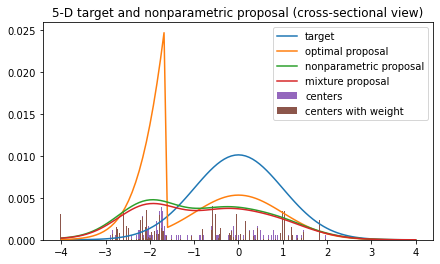

==RIS================================================RIS==
Numerator R2: 0.4588; Denominator R2: 0.8618
RIS a-var: 0.5092; a-err: 0.0023
==MLE================================================MLE==
MLE reference:
origin: value: 8.5185; grad: (min -0.2239, mean -0.0132, max 0.1360, std 0.0340)

Theoretical results:
MLE(The) zeta: (min -0.0623, mean -0.0000, max 0.1186, std 0.0086, norm 0.2626)
theory: value: nan; grad: (min -6.0418, mean 0.0042, max 4.4047, std 0.3341)
reg weights: (min -0.5563, mean 0.9962, max 19.4043, [<0] 10/100000)
RIS est: -1.6425; err: 0.0023
(adjusted) RIS est: -1.6425; err: 0.0023
mle weights (The): (min -570.3527, mean 1.0004, max 720.8208, [<0] 29/100000)
MLE(The) est: -1.6402; err: 0.0046
(adjusted) MLE(The) est: -1.6390; err: 0.0059

Optimization results (spent 33 seconds):
MLE(Opt) zeta: (min -0.0771, mean -0.0000, max 0.1182, std 0.0095, norm 0.2898)
Dist(zeta(Opt),zeta(The))=0.0848
optimal: value: nan; grad: (min -0.0000, mean -0.0000, max 0.0000, std 0.00

In [4]:
np.random.seed(1997)
print('==IS==================================================IS==')
mle=MLE(dim=5,alpha=0.05,sigma=2,size=100000,df=1)
mle.estimate_IS()
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('==NIS================================================NIS==')
mle.resample(1000,100)
mle.estimate_NIS(0.9,reg=0)
mle.draw_TP(mle.nP,x,'nonparametric')
print('==RIS================================================RIS==')
mle.estimate_RIS()
print('==MLE================================================MLE==')
mle.estimate_MLE()

**Summary:**
* Because the tail part is small, kernels of this part are highly correlated. (AB)
* Regression can break the variance limit of self-normalized IS. 
* The performance of regression and MLE is limited by the tail approximation. (AB)
* Rooting finding algorithm works will for control variables with only kernels. 
* Some weights based on regression or MLE are negative due to high density of the mixture proposal in the tail of the target, but the result is still somehow accurate and adjustment don't make too much difference. 

**Future:**
* Maybe addaptive bandwidth can help solving the tail part problems. 